In [88]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ast import literal_eval

import re
import string

In [89]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [90]:
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

In [91]:
import spacy
from rake_nltk import Rake

In [92]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS

In [93]:
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

In [94]:
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler

In [95]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

In [96]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

## 1) Read in the data

In [97]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)
print(movies.shape)
movies.head()

(47723, 8)


,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"['tom_hanks', 'tim_allen', 'don_rickles', 'jim..."
1,2,8844,113497,Jumanji,"['Adventure', 'Children', 'Fantasy']",When siblings Judy and Peter discover an encha...,joe_johnston,"['robin_williams', 'kirsten_dunst', 'bradley_p..."
2,3,15602,113228,Grumpier Old Men,"['Comedy', 'Romance']",A family wedding reignites the ancient feud be...,howard_deutch,"['walter_matthau', 'jack_lemmon', 'ann-margret..."
3,4,31357,114885,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"['whitney_houston', 'angela_bassett', 'loretta..."
4,5,11862,113041,Father of the Bride Part II,['Comedy'],Just when George Banks has recovered from his ...,charles_shyer,"['steve_martin', 'diane_keaton', 'martin_short..."


#### Lists in columns got turned into text strings during save to csv; need to undo that

In [98]:
movies['genres'] = movies['genres'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]"
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim..."


## 2) Tokenize the 'overview' column

#### This time, we'll try the rake_nltk keyword extractor on the corpus

#### Start by removing digits, capital letters and punctuation

In [102]:
alpha = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_and_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

movies['plot_tokens'] = movies['overview'].map(alpha).map(punc_and_lower)

In [103]:
raker = Rake(stopwords=list(STOPWORDS), max_length=2)

movies['plot_tokens'] = ''
for n, row in movies.iterrows():
    raker.extract_keywords_from_text(row['overview'])
    movies.at[n,'plot_tokens'] = raker.get_ranked_phrases()

In [104]:
movies['plot_tokens']

0        [s heart, woody plots, woody, woody, scene, ro...
1        [trapped inside, terrifying creatures, sibling...
2        [ll scare, hot time, fish away, door neighbors...
3        [stellar lovers, robin talk, good man, confida...
4        [s wife, s wedding, george banks, s, george, s...
                               ...                        
47718    [time work, time job, yakumo miko, miko asks, ...
47719    [nearly turns, mixed emotions, household upsid...
47720    [later exposing, involves seducing, big city, ...
47721    [uncharted forest, ancient organism, expeditio...
47722    [special forces, national anti, drug trafficki...
Name: plot_tokens, Length: 47723, dtype: object

In [105]:
movies['genres'] = movies['genres'].map(lambda x: [el.lower() for el in x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]","[s heart, woody plots, woody, woody, scene, ro..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...","[trapped inside, terrifying creatures, sibling..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...","[ll scare, hot time, fish away, door neighbors..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...","[stellar lovers, robin talk, good man, confida..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...","[s wife, s wedding, george banks, s, george, s..."


In [106]:
movies['director'] = movies['director'].map(lambda x: [x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[s heart, woody plots, woody, woody, scene, ro..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[trapped inside, terrifying creatures, sibling..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[ll scare, hot time, fish away, door neighbors..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[stellar lovers, robin talk, good man, confida..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[s wife, s wedding, george banks, s, george, s..."


#### Combine all tokens into one 'corpus' column

In [107]:
cols = ['genres', 'director', 'actors', 'plot_tokens']

movies['corpus'] = ''

for n, row in movies.iterrows():
    val = ''
    for col in cols:
        val += ' '.join(row[col])
        val += ' '
    movies.at[n,'corpus'] = val

In [108]:
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[s heart, woody plots, woody, woody, scene, ro...",adventure animation children comedy fantasy jo...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[trapped inside, terrifying creatures, sibling...",adventure children fantasy joe_johnston robin_...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[ll scare, hot time, fish away, door neighbors...",comedy romance howard_deutch walter_matthau ja...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[stellar lovers, robin talk, good man, confida...",comedy drama romance forest_whitaker whitney_h...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[s wife, s wedding, george banks, s, george, s...",comedy charles_shyer steve_martin diane_keaton...


In [109]:
movies['corpus'][0]

'adventure animation children comedy fantasy john_lasseter tom_hanks tim_allen don_rickles jim_varney s heart woody plots woody woody scene room place owner losing led differences buzz aside andy andy andy afraid '

#### Build a Stemmer and Stopword function for use w/ the Vectorizer; Let's use a "better" English stopword list than the NLTK default

In [110]:
# Using the "better" Gensim English STOPWORDS list instead of the NLTK default list

stemmer = SnowballStemmer('english')

def prep(word, stemmer=stemmer):
    
    stopwords = list(STOPWORDS)
        
    if word.lower() in stopwords:
        return None
    
    elif stemmer is None:
        return word.lower()
    
    else:
        return stemmer.stem(word)

In [111]:
# CountVectorizer(stop_words=None, max_df=0.7, )

cv1 = CountVectorizer(stop_words=None, preprocessor=prep, ngram_range=(1, 2), min_df=0.045)

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())
doc_term.shape

(47723, 38)

In [112]:
doc_term.head()

,action,adventure,children,comedy,comedy drama,crime,crime drama,documentary,drama,drama romance,family,fantasy,father,fi,film,finds,friends,help,horror,life,lives,love,man,mystery,new,romance,sci,sci fi,story,thriller,time,war,way,wife,woman,world,years,young
0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Now apply dimensionality reduction to the dataset

In [113]:
svd = TruncatedSVD(n_components=30, n_iter=50, random_state=42)
svd.fit(X_cv1.T)

TruncatedSVD(n_components=30, n_iter=50, random_state=42)

In [114]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

[0.10715254 0.08574581 0.06553475 0.05131352 0.04693059 0.04430041
 0.03971665 0.0345731  0.02931889 0.03021468 0.02858282 0.02755101
 0.02678975 0.02522483 0.02362543 0.02297272 0.02217738 0.0211323
 0.02056945 0.02025246 0.01950959 0.01843949 0.01804702 0.01728948
 0.01603248 0.01548206 0.01464257 0.0147881  0.01447349 0.01406713]
0.936450517705011


In [115]:
svd.components_.T.shape

(47723, 30)

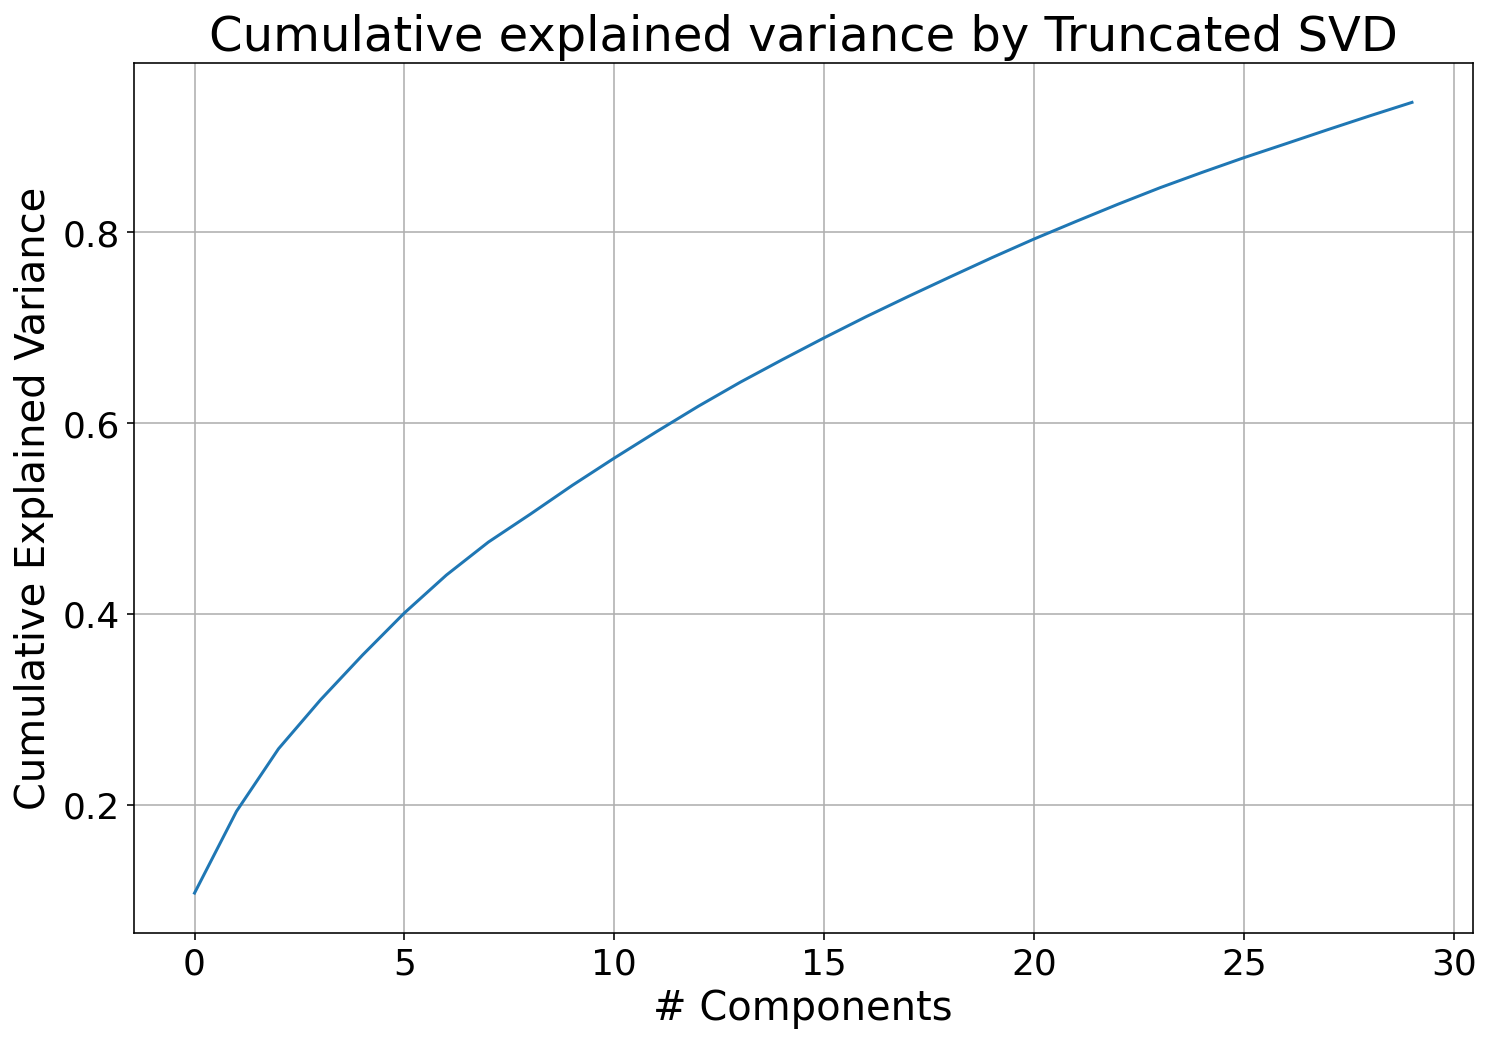

In [116]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# Components', size=20)
plt.ylabel('Cumulative Explained Variance', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Cumulative explained variance by Truncated SVD', size=24)
plt.grid();

In [117]:
mat = pd.DataFrame(data=svd.components_.T, index=movies.index)
mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.002760,0.007637,0.003112,0.000989,0.000784,-0.003773,0.004942,-0.005896,0.000840,0.007632,-0.002936,-0.003385,-0.012852,0.007119,-0.002785,-0.004449,-0.004658,0.001132,-0.004329,-0.003623,-0.002308,0.000889,0.002657,0.000029,-0.000067,-0.001829,-0.004008,0.001328,0.000644,-0.001809
1,0.001371,0.001060,0.003283,-0.002897,0.001782,-0.002627,0.006531,-0.007833,0.002960,0.006527,-0.005775,-0.006025,-0.014919,0.006604,-0.004091,-0.006027,0.006430,-0.006820,-0.004713,-0.003255,-0.001750,-0.003536,-0.000899,0.000283,0.000063,-0.001948,-0.004982,0.001731,0.000748,-0.000532
2,0.003406,0.008183,-0.000470,-0.000836,-0.003740,0.003811,0.000265,0.001126,-0.000762,-0.000410,-0.002508,-0.004160,0.000785,0.000488,-0.001471,0.002139,-0.000762,0.002371,0.003681,0.000828,0.014354,-0.003336,0.002754,-0.001936,0.000053,0.000994,-0.003478,-0.000785,0.000152,-0.000698
3,0.009336,0.006368,-0.004814,-0.001837,-0.006508,0.001303,-0.002612,0.000696,-0.001270,-0.003250,0.008043,-0.009243,-0.000172,-0.002609,0.000640,-0.003063,0.002375,0.001060,-0.006307,0.000526,0.001891,0.000909,0.002398,-0.005957,-0.002661,-0.003015,0.016996,-0.008574,-0.005557,-0.001493
4,0.002138,0.006612,0.000771,0.003261,0.000213,-0.001423,-0.001133,0.000172,-0.000037,-0.000802,0.001267,0.000138,0.000683,0.001016,-0.001465,0.000141,-0.000582,0.002551,0.000165,0.000451,0.001945,0.002087,-0.009232,0.012645,-0.005170,-0.001236,-0.002845,-0.002506,0.000660,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,0.004375,-0.003002,-0.001660,-0.000776,0.000704,-0.004089,-0.000528,-0.000705,0.001042,-0.000134,-0.001597,-0.000148,-0.002181,-0.000764,-0.001316,0.002630,0.001052,0.006771,0.007782,0.000312,0.029531,-0.005585,0.006148,-0.004541,0.000428,0.000870,-0.006964,-0.002000,-0.000094,0.000120
47719,0.002138,0.006612,0.000771,0.003261,0.000213,-0.001423,-0.001133,0.000172,-0.000037,-0.000802,0.001267,0.000138,0.000683,0.001016,-0.001465,0.000141,-0.000582,0.002551,0.000165,0.000451,0.001945,0.002087,-0.009232,0.012645,-0.005170,-0.001236,-0.002845,-0.002506,0.000660,0.001449
47720,0.003600,-0.003381,-0.002553,0.000227,-0.000590,-0.004104,-0.001252,0.000545,-0.001229,0.000130,0.000531,0.000970,-0.001329,-0.000989,0.000713,-0.000756,0.000513,0.000450,-0.000488,-0.000510,0.000168,0.000389,0.000320,-0.000138,0.000329,0.000238,-0.000388,-0.000173,-0.000691,0.000083
47721,0.005169,-0.003329,0.009679,-0.010654,-0.002379,-0.009009,-0.007150,0.003573,0.000926,0.003431,-0.001323,-0.000123,-0.004277,0.003875,0.008417,-0.002906,-0.002512,0.000986,-0.005044,-0.002743,-0.001617,0.000728,0.009353,0.005567,-0.003714,-0.004669,-0.002000,-0.000639,0.000566,0.000923


#### Compute Cosine Similarities in this reduced space

In [118]:
del doc_term

cosine_sim = cosine_similarity(mat, mat)
del mat

print(cosine_sim.shape)
print(cosine_sim)
# np.save('cosine_similarities.npy', cosine_sim)

(47723, 47723)
[[ 1.          0.76316709  0.04915656 ... -0.04549871  0.27476506
  -0.09263224]
 [ 0.76316709  1.         -0.06047957 ... -0.02072666  0.18733924
  -0.08243939]
 [ 0.04915656 -0.06047957  1.         ... -0.22029353 -0.13308976
  -0.08652294]
 ...
 [-0.04549871 -0.02072666 -0.22029353 ...  1.          0.31038865
   0.26532716]
 [ 0.27476506  0.18733924 -0.13308976 ...  0.31038865  1.
   0.00990278]
 [-0.09263224 -0.08243939 -0.08652294 ...  0.26532716  0.00990278
   1.        ]]


In [19]:
# cosine_sim = np.load('cosine_similarities.npy')

In [119]:
def recommend(movie_id, len=20):
    movie_idx = movies[movies['movieId'] == movie_id].index[0]
    rec_indices = cosine_sim[movie_idx,:].argsort()[::-1][0:len+1]
    rec_indices = [rec_idx for rec_idx in rec_indices if rec_idx != movie_idx]
    print('Recommendations based on your interest in {}:'
               .format(movies[movies['movieId'] == movie_id]['title'].values[0]))
    recommendations = movies.iloc[rec_indices, np.r_[3:5, 6:8]]
    recommendations['relevancy'] = cosine_sim[movie_idx, rec_indices]
    return recommendations

In [120]:
recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
14959,The Wizard of Oz,"[adventure, children, comedy, fantasy]",[larry_semon],"[dorothy_dwan, mary_carr, charles_murray, oliv...",1.0
10841,The Ant Bully,"[adventure, animation, children, comedy, fanta...",[john_a._davis],"[julia_roberts, meryl_streep, nicolas_cage, pa...",1.0
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",1.0
23645,A Connecticut Yankee in King Arthur's Court,"[adventure, children, comedy, fantasy]",[mel_damski],"[keshia_knight_pulliam, michael_gross, jean_ma...",1.0
9801,DuckTales: The Movie - Treasure of the Lost Lamp,"[adventure, animation, children, comedy, fantasy]",[bob_hathcock],"[alan_young, terence_mcgovern, russi_taylor, r...",1.0
20549,Adventures of a Teenage Dragonslayer,"[adventure, children, comedy, fantasy]",[andrew_lauer],"[amy_pietz, eric_lutes, hunter_allan, lea_thom...",1.0
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",1.0
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",1.0
6916,Chitty Chitty Bang Bang,"[adventure, children, comedy, fantasy, musical]",[ken_hughes],"[dick_van_dyke, sally_ann_howes, lionel_jeffri...",1.0
55,Kids of the Round Table,"[adventure, children, comedy, fantasy]",[robert_tinnell],"[johnny_morina, malcolm_mcdowell, maggie_castl...",1.0


In [34]:
movies[movies['title'] == 'Chinatown']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1161,1252,829,71315,Chinatown,"[crime, film-noir, mystery, thriller]",Private eye Jake Gittes lives off of the murky...,[roman_polanski],"[jack_nicholson, faye_dunaway, john_huston, pe...","[private, eye, jake, gittes, lives, off, of, t...",crime film-noir mystery thriller roman_polansk...


In [121]:
recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
8838,A Pure Formality,"[crime, film-noir, mystery, thriller]",[giuseppe_tornatore],"[gérard_depardieu, roman_polanski, sergio_rubi...",1.000000
8531,"Farewell, My Lovely","[crime, mystery, thriller]",[dick_richards],"[robert_mitchum, charlotte_rampling, sylvia_mi...",1.000000
1489,L.A. Confidential,"[crime, film-noir, mystery, thriller]",[curtis_hanson],"[kevin_spacey, russell_crowe, guy_pearce, jame...",1.000000
16357,Vice,"[crime, film-noir, mystery, thriller]",[raul_inglis],"[michael_madsen, daryl_hannah, mykelti_william...",1.000000
157,Devil in a Blue Dress,"[crime, film-noir, mystery, thriller]",[carl_franklin],"[denzel_washington, tom_sizemore, jennifer_bea...",0.953964
22141,Backfire,"[crime, film-noir, mystery, romance, thriller]",[vincent_sherman],"[virginia_mayo, gordon_macrae, edmond_o'brien,...",0.941188
27044,The Man Who Wouldn't Die,"[crime, drama, thriller]",[bill_condon],"[roger_moore, malcolm_mcdowell, nancy_allen, j...",0.934485
27558,Too Late for Tears,"[crime, drama, film-noir, mystery, thriller]",[byron_haskin],"[lizabeth_scott, don_defore, dan_duryea, arthu...",0.934485
17016,Follow Me Quietly,"[crime, drama, film-noir, mystery]",[richard_fleischer],"[william_lundigan, dorothy_patrick, jeff_corey...",0.934485
32702,Khamosh,"[mystery, thriller]",[vidhu_vinod_chopra],"[amol_palekar, naseeruddin_shah, shabana_azmi,...",0.917584


In [36]:
movies[movies['title'] == 'Raging Bull']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1139,1228,1578,81398,Raging Bull,[drama],"The life of boxer Jake LaMotta, whose violence...",[martin_scorsese],"[robert_de_niro, joe_pesci, cathy_moriarty, fr...","[the, life, of, boxer, jake, lamotta, whose, v...",drama martin_scorsese robert_de_niro joe_pesci...


In [122]:
recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
9294,Beyond the Sea,"[drama, musical]",[kevin_spacey],"[kevin_spacey, kate_bosworth, john_goodman, bo...",1.0
13936,Through the Mist,[drama],[jean-philippe_duval],"[sébastien_ricard, joseph_mesiano, dimitri_sto...",1.0
17470,Shit Year,[drama],[cam_archer],"[ellen_barkin, luke_grimes, bob_einstein, ther...",1.0
21932,Bright Lights,"[drama, musical]",[michael_curtiz],"[dorothy_mackaill, frank_fay, noah_beery, daph...",1.0
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",1.0
1441,The Last Time I Committed Suicide,[drama],[stephen_t._kay],"[thomas_jane, keanu_reeves, claire_forlani, gr...",1.0
3964,The Greatest Story Ever Told,[drama],[george_stevens],"[max_von_sydow, michael_anderson_jr., carroll_...",1.0
35184,Found Memories,[drama],[julia_murat],"[sônia_guedes, lisa_fávero, luiz_serra, ricard...",1.0
46016,Once there was a woman,[drama],[andrey_smirnov],"[nina_ruslanova, vladislav_abashin, roman_mady...",1.0
12356,The Color of Pomegranates,[drama],[sergei_parajanov],"[spartak_bagashvili, sofiko_chiaureli, medea_j...",1.0


In [38]:
movies[movies['title'] == 'Happy Gilmore']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
102,104,9614,116483,Happy Gilmore,[comedy],Failed hockey player-turned-golf whiz Happy Gi...,[dennis_dugan],"[adam_sandler, christopher_mcdonald, julie_bow...","[failed, hockey, player, turned, golf, whiz, h...",comedy dennis_dugan adam_sandler christopher_m...


In [123]:
recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
17,Four Rooms,[comedy],[allison_anders],"[tim_roth, jennifer_beals, antonio_banderas, v...",1.0
29904,"Oggi, domani, dopodomani",[comedy],[eduardo_de_filippo],"[marcello_mastroianni, catherine_spaak, virna_...",1.0
37248,Fast Break,[comedy],[jack_smight],"[gabe_kaplan, harold_sylvester, michael_warren...",1.0
42030,Ducoboo,[comedy],[philippe_de_chauveron],"[elie_semoun, joséphine_de_meaux, vincent_clau...",1.0
37249,The Sporting Club,[comedy],[larry_peerce],"[robert_fields, nicolas_coster, margaret_blye,...",1.0
2115,The Impostors,[comedy],[stanley_tucci],"[oliver_platt, stanley_tucci, tony_shalhoub, s...",1.0
2116,A Night at the Roxbury,[comedy],[john_fortenberry],"[chris_kattan, will_ferrell, dan_hedaya, molly...",1.0
2120,The Producers,[comedy],[mel_brooks],"[zero_mostel, gene_wilder, dick_shawn, kenneth...",1.0
2121,History of the World: Part I,"[comedy, musical]",[mel_brooks],"[mel_brooks, dom_deluise, madeline_kahn, harve...",1.0
39900,The Fabulous Patars,[comedy],[sophie_reine],"[gustave_kervern, camille_cottin, fanie_zanini...",1.0


In [40]:
movies[movies['title'] == "You've Got Mail"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2242,2424,9489,128853,You've Got Mail,"[comedy, romance]","Book superstore magnate, Joe Fox and independe...",[nora_ephron],"[tom_hanks, meg_ryan, greg_kinnear, parker_posey]","[book, superstore, magnate, joe, fox, and, ind...",comedy romance nora_ephron tom_hanks meg_ryan ...


In [124]:
recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
15734,Mujhse Shaadi Karogi,"[comedy, romance]",[david_dhawan],"[salman_khan, priyanka_chopra, akshay_kumar, a...",1.0
41482,The Blonde Around the Corner,"[comedy, romance]",[vladimir_bortko],"[andrey_mironov, tatyana_dogileva, yelena_solo...",1.0
37934,Here Come the Waves,"[comedy, romance]",[mark_sandrich],"[bing_crosby, betty_hutton, sonny_tufts, ann_d...",1.0
21186,The Gilded Lily,"[comedy, romance]",[wesley_ruggles],"[claudette_colbert, fred_macmurray, ray_millan...",1.0
19164,Excuse Me for Living,"[comedy, romance]",[ric_klass],"[tom_pelphrey, christopher_lloyd, robert_vaugh...",1.0
11197,The Young Girls of Rochefort,"[comedy, musical, romance]",[jacques_demy],"[catherine_deneuve, françoise_dorléac, jacques...",1.0
26521,Paris-Manhattan,"[comedy, romance]",[sophie_lellouche],"[alice_taglioni, patrick_bruel, marine_delterm...",1.0
15960,"Rich, Young and Pretty","[comedy, musical, romance]",[norman_taurog],"[jane_powell, danielle_darrieux, wendell_corey...",1.0
19834,Three Smart Girls Grow Up,"[comedy, musical, romance]",[henry_koster],"[deanna_durbin, charles_winninger, nan_grey, h...",1.0
46712,Foam Party!,"[comedy, romance]",[roberto_pérez_toledo],"[sara_sálamo, diego_martínez, nacho_san_josé, ...",1.0


In [42]:
movies[movies['title'] == "Reservoir Dogs"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1020,1089,500,105236,Reservoir Dogs,"[crime, mystery, thriller]",A botched robbery indicates a police informant...,[quentin_tarantino],"[harvey_keitel, tim_roth, michael_madsen, chri...","[a, botched, robbery, indicates, a, police, in...",crime mystery thriller quentin_tarantino harve...


In [125]:
recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
45425,Murder on the Home Front,"[crime, mystery, thriller]",[geoffrey_sax],"[tamzin_merchant, patrick_kennedy, emerald_fen...",1.0
36401,Big Driver,"[crime, mystery, thriller]",[mikael_salomon],"[maria_bello, joan_jett, ann_dowd, olympia_duk...",1.0
7950,Murder on the Orient Express,"[crime, mystery, thriller]",[sidney_lumet],"[albert_finney, lauren_bacall, martin_balsam, ...",1.0
29693,The Perfect Student,"[crime, mystery, thriller]",[michael_feifer],"[natasha_henstridge, brea_grant, robert_neary,...",1.0
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",1.0
34112,La Tête d'un homme,"[crime, mystery, thriller]",[julien_duvivier],"[harry_baur, valéry_inkijinoff, alexandre_rign...",1.0
15621,Illustrious Corpses,"[crime, mystery, thriller]",[francesco_rosi],"[lino_ventura, tino_carraro, marcel_bozzuffi, ...",1.0
12565,Righteous Kill,"[crime, mystery, thriller]",[jon_avnet],"[robert_de_niro, al_pacino, carla_gugino, john...",1.0
28220,Beck 30 - The Hospital Murders,"[crime, mystery, thriller]",[stephan_apelgren],"[mikael_persbrandt, peter_haber, ingvar_hirdwa...",1.0
38529,Brimstone,"[mystery, thriller, western]",[martin_koolhoven],"[guy_pearce, dakota_fanning, carice_van_houten...",1.0


In [44]:
movies[movies['title'] == "Star Wars"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
252,260,11,76759,Star Wars,"[action, adventure, sci-fi]",Princess Leia is captured and held hostage by ...,[george_lucas],"[mark_hamill, harrison_ford, carrie_fisher, pe...","[princess, leia, is, captured, and, held, host...",action adventure sci-fi george_lucas mark_hami...


In [126]:
recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
46116,Time Trap,"[action, adventure, sci-fi]",[ben_foster],"[andrew_wilson, cassidy_gifford, brianne_howey...",1.0
39766,Dakota Bound,"[action, adventure, sci-fi]",[lloyd_a._simandl],"[fawnia_mondey, esther_hanuka, john_comer, eva...",1.0
31652,Robo Warriors,"[action, adventure, sci-fi]",[ian_barry],"[kyle_howard, james_remar, terry_markwell, jam...",1.0
18863,Journey to Saturn,"[action, adventure, animation, sci-fi]",[kresten_vestbjerg_andersen],"[casper_christensen, frank_hvam, ali_kazim, ib...",1.0
3577,X-Men,"[action, adventure, sci-fi]",[bryan_singer],"[hugh_jackman, patrick_stewart, ian_mckellen, ...",1.0
38579,Max Steel,"[action, adventure, sci-fi]",[stewart_hendler],"[ben_winchell, josh_brener, ana_villafañe, and...",1.0
29625,Robot Overlords,"[action, adventure, sci-fi]",[jon_wright],"[ben_kingsley, gillian_anderson, callan_mcauli...",1.0
45851,Juarez 2045,"[action, adventure, sci-fi]",[chris_le],"[danny_trejo, alex_heartman, blake_webb, brad_...",1.0
12509,Star Wars: The Clone Wars,"[action, adventure, animation, sci-fi]",[dave_filoni],"[matt_lanter, ashley_eckstein, james_arnold_ta...",1.0
16553,Green Lantern,"[action, adventure, sci-fi]",[martin_campbell],"[ryan_reynolds, blake_lively, peter_sarsgaard,...",1.0
